# Planar flow

In [3]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
K = 16
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
    (10): Planar()
    (11): Planar()
    (12): Planar()
    (13): Planar()
    (14): Planar()
    (15): Planar()
  )
)

/home/mahrokhg/anaconda3/envs/NOC/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755934348/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


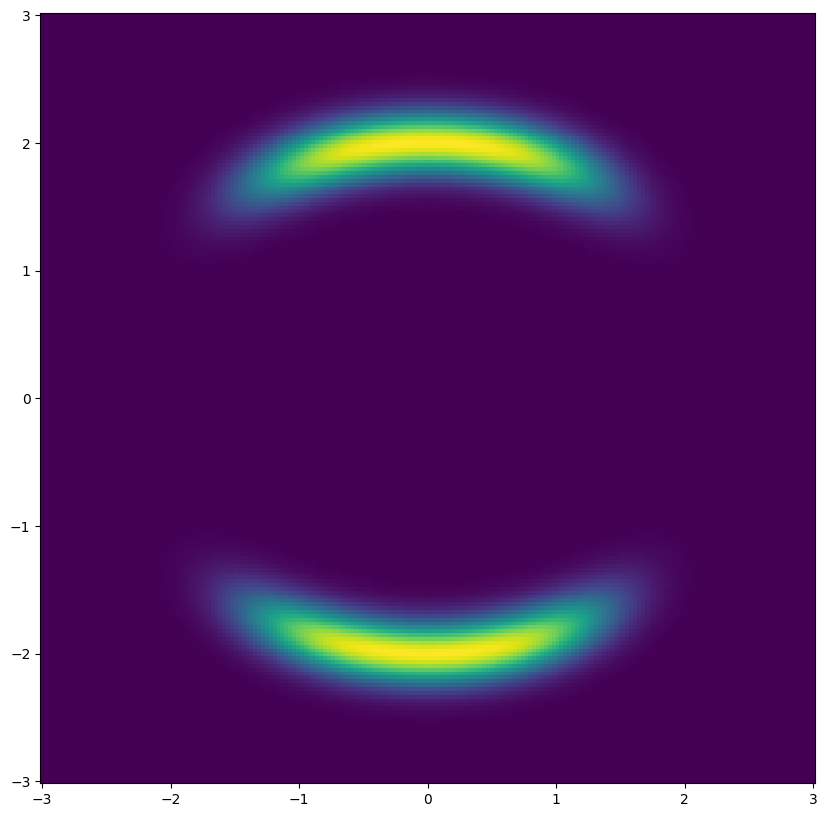

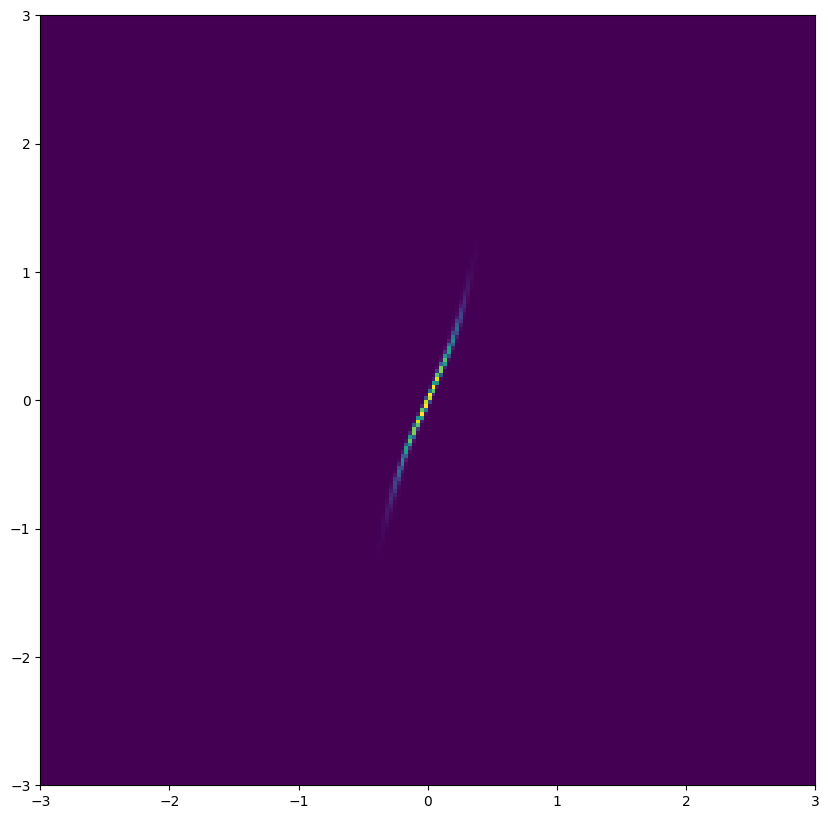

In [5]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(10, 10))
plt.pcolormesh(torch.linspace(-3, 3, grid_size),torch.linspace(-3, 3, grid_size), prob, shading='nearest')
plt.show()

# Plot initial flow distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

 10%|▉         | 1996/20000 [00:53<07:58, 37.60it/s]

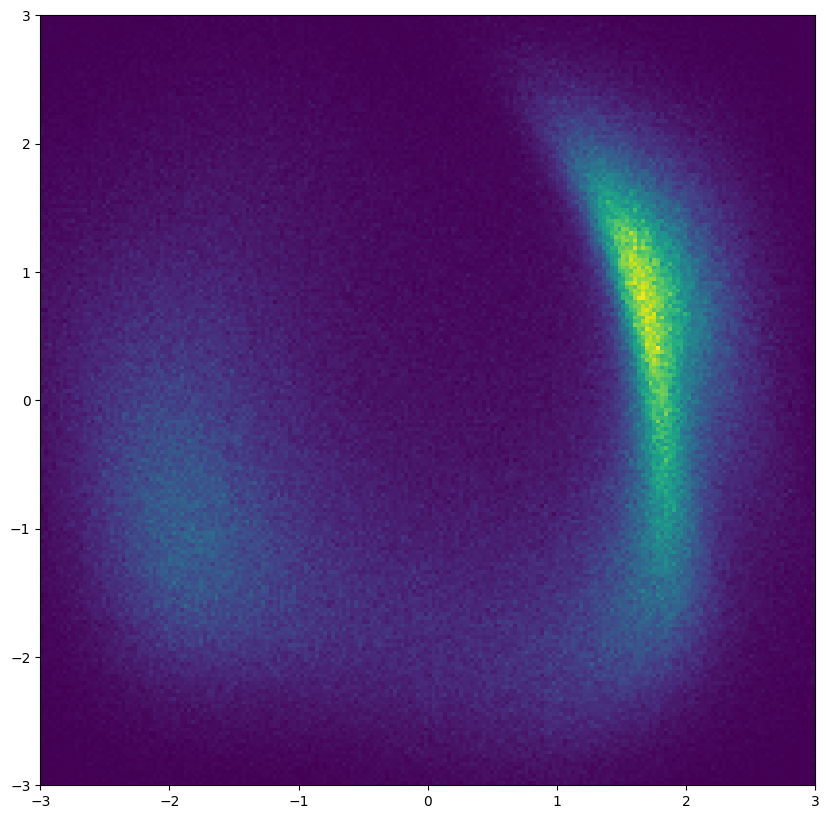

 20%|█▉        | 3996/20000 [01:46<07:05, 37.59it/s]

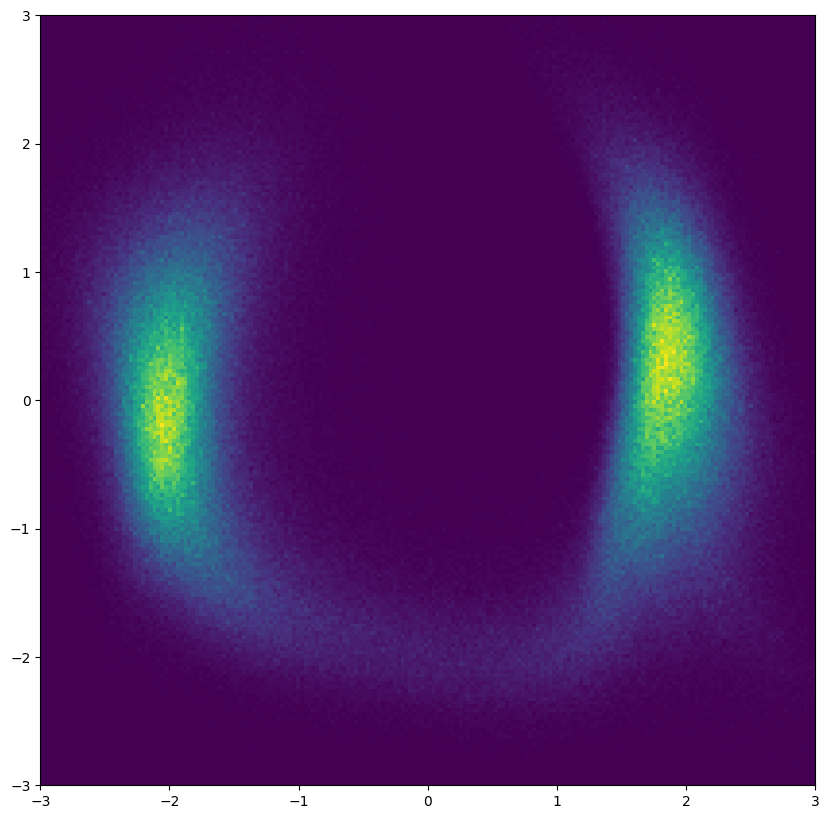

 30%|██▉       | 5997/20000 [02:40<06:09, 37.92it/s]

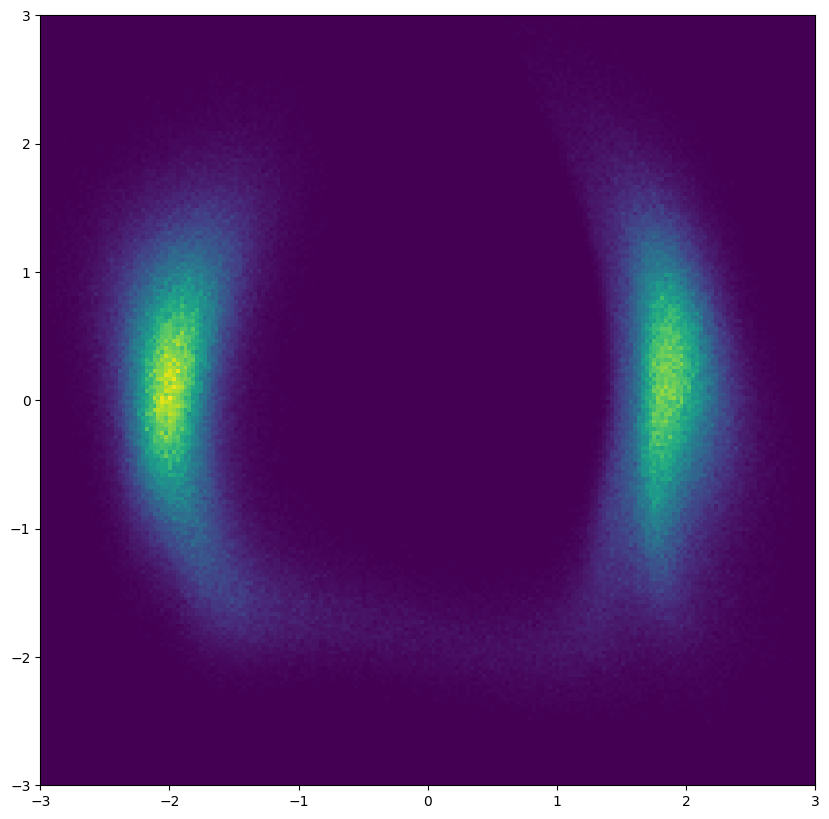

 40%|███▉      | 7998/20000 [03:32<05:06, 39.18it/s]

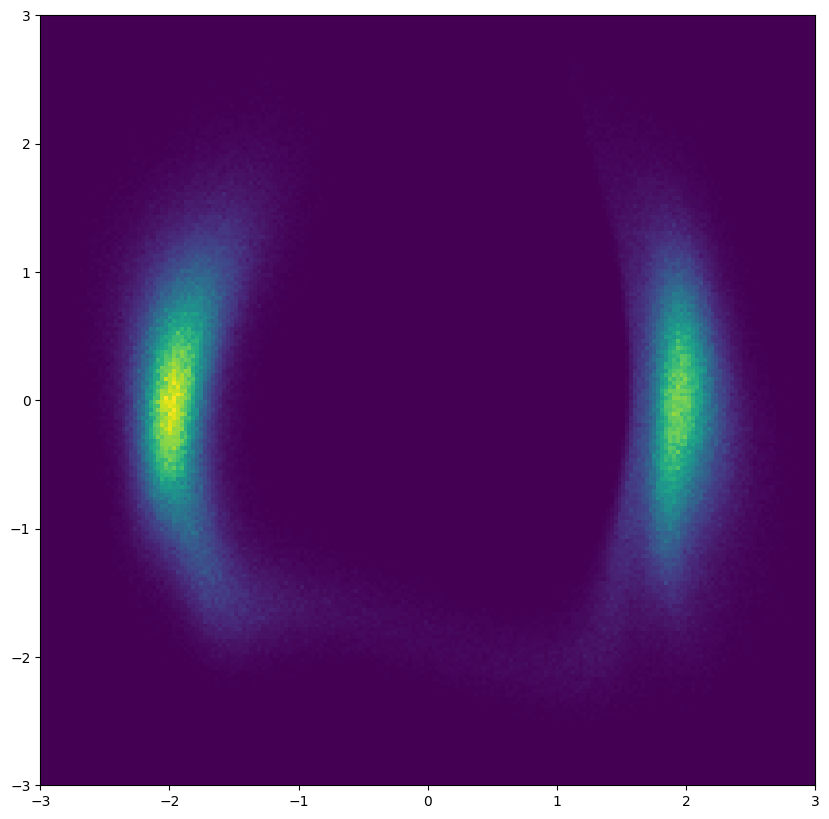

 50%|████▉     | 9998/20000 [04:23<04:14, 39.30it/s]

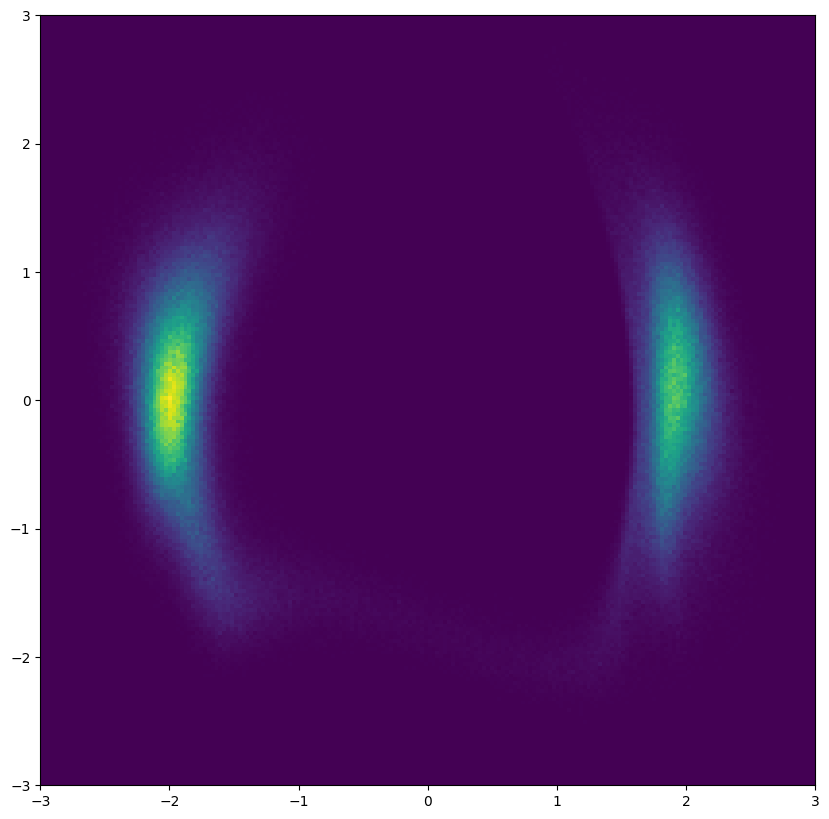

 60%|█████▉    | 11999/20000 [05:15<03:24, 39.03it/s]

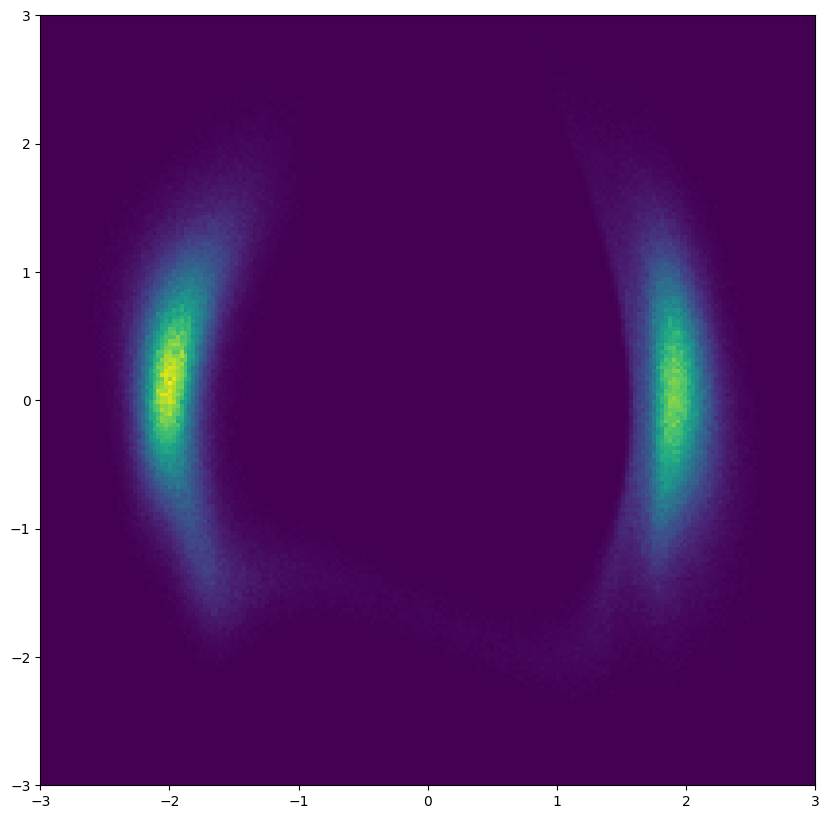

 70%|██████▉   | 13997/20000 [06:07<02:40, 37.38it/s]

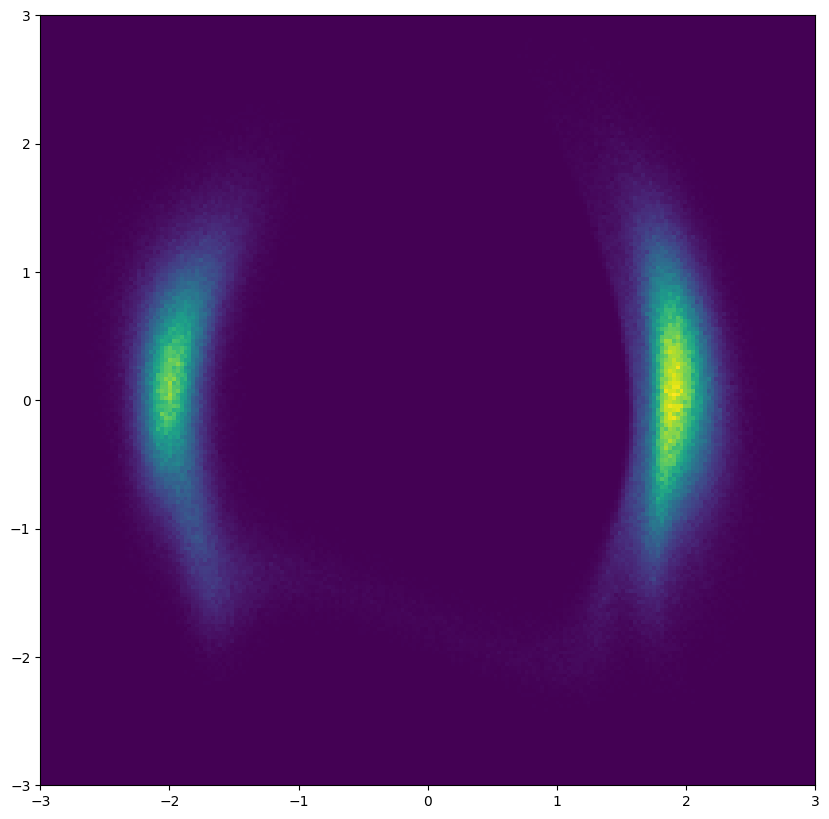

 80%|███████▉  | 15998/20000 [07:01<01:46, 37.46it/s]

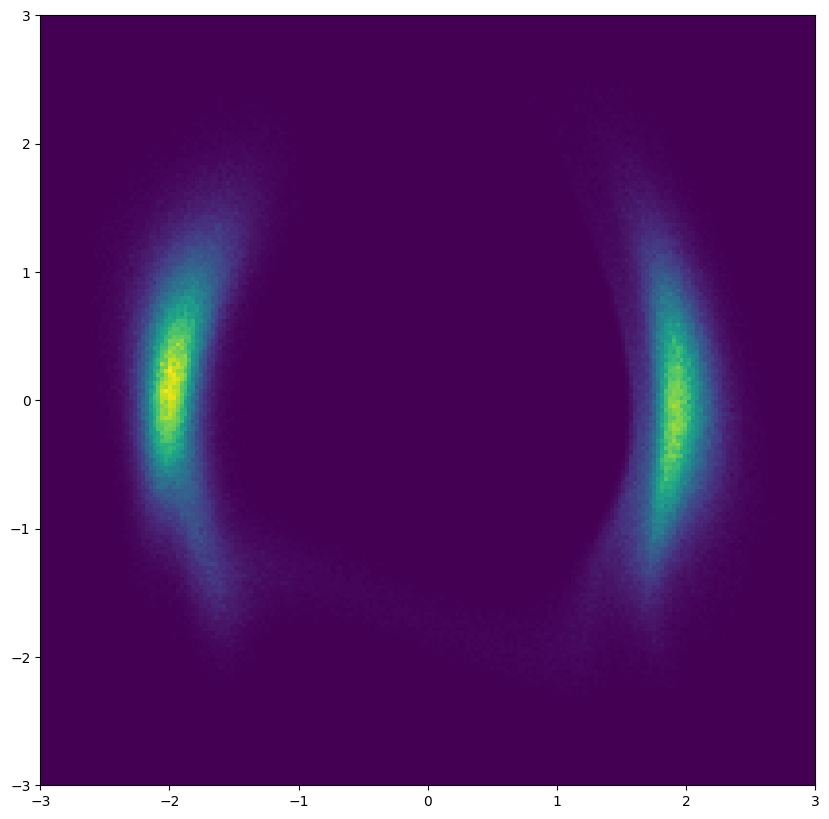

 90%|████████▉ | 17999/20000 [07:54<00:52, 37.86it/s]

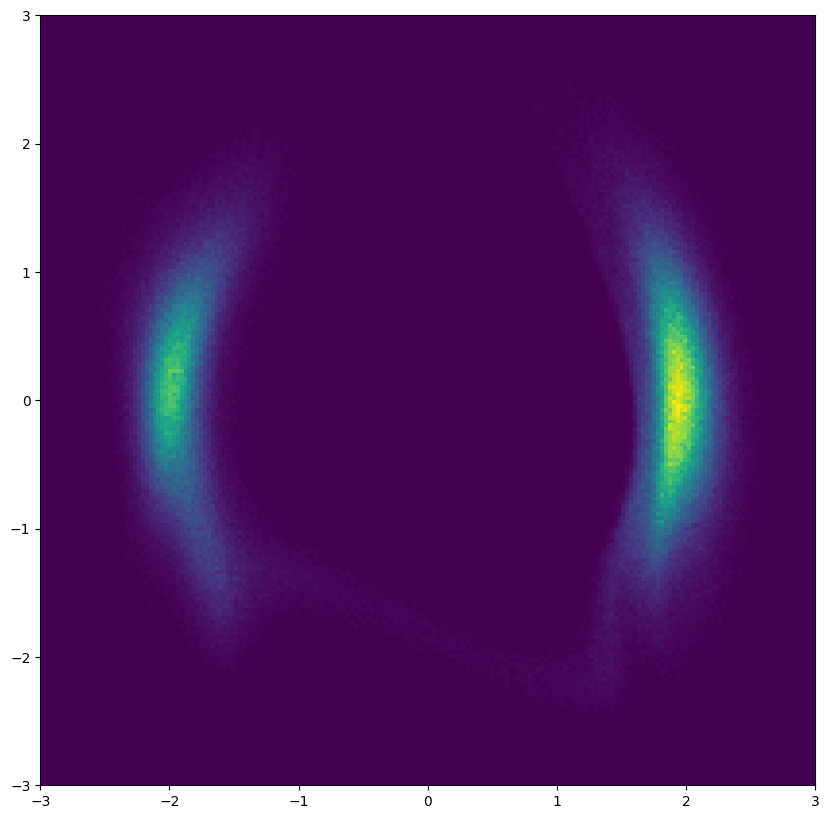

100%|█████████▉| 19996/20000 [08:47<00:00, 37.90it/s]

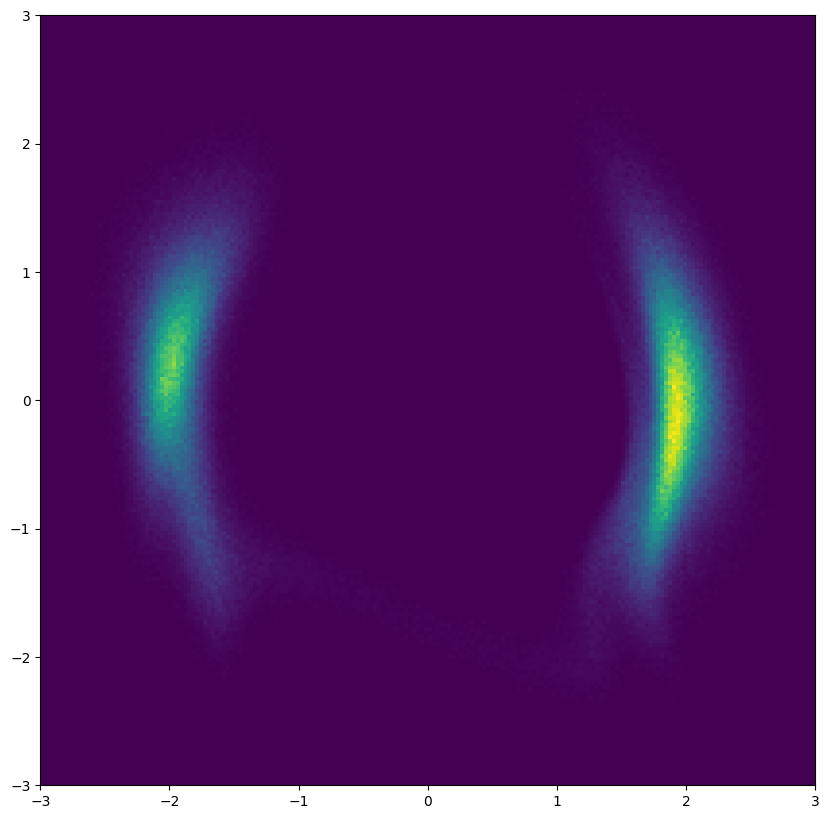

100%|██████████| 20000/20000 [08:48<00:00, 37.87it/s]


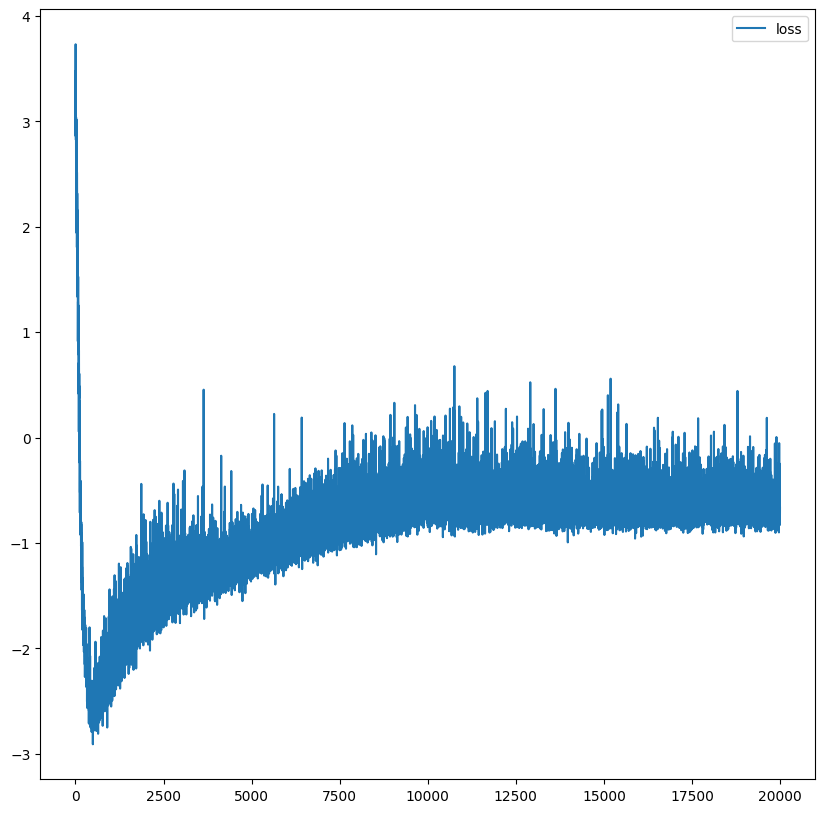

In [6]:
# Train model
max_iter = 20000
num_samples = 2 * 20
anneal_iter = 10000
annealing = True
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = nfm.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        torch.cuda.manual_seed(0)
        z, _ = nfm.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()
        
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

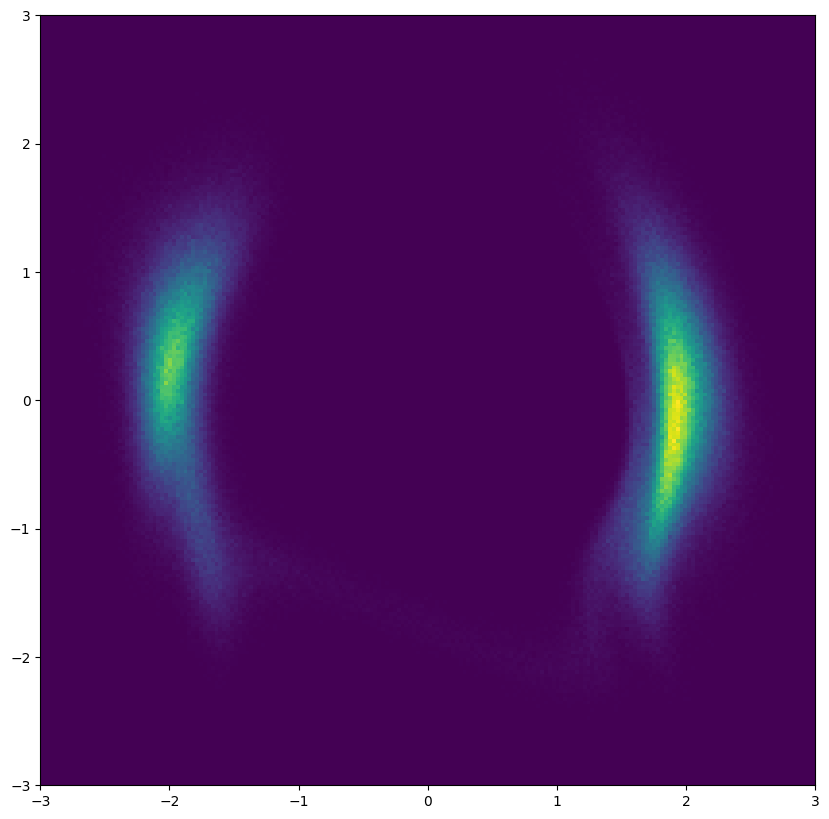

In [7]:
# Plot learned distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

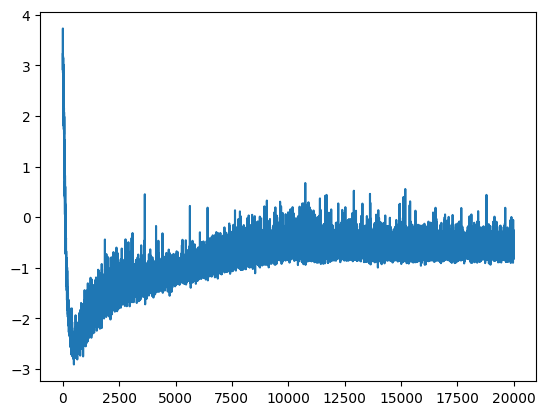

In [8]:
plt.plot(loss_hist)